# Machine Learning Models: 

## Description
The Dutch study from University of Groningen, where the datasets were published, suggests that it is possible to predict injuries with a machine learning model.

After my own analysis I could see significant differences between injury=0 and injury=1 for several features. 

But no significant correlations!

The secret must be somewhere else!

And one particularity came up as sort of a pattern - not only the difference between injury=0 or injury=1 (horizontal comparing) was visible but also the difference between one feature compared with itself over the time (vertical comparing) was frapping more diverse.


## aim
Build new Δ-columns to add to the datasets for training a prediction model

![Bildschirmfoto 2025-03-14 um 13.53.32.png](<attachment:Bildschirmfoto 2025-03-14 um 13.53.32.png>)

## process
1. aggregate the Delta columns for the features 
    - Sessions
    - Rest Days
    - Total Km
    - high intensity (Heartrate Zone 5)
2. testing significance
3. testing correlation
4. start training the model / data splitting / training / evaluation
    - Logistic Regression - no satisfactory result
    - Random Forest - no satisfactory result

## result
Accordingly to the analysis part we could not find correlations for the Delta columns either.

And although the new Delta columns seemed to have a higher feature importance for prediction models, we couldn't invest more time to optimize it.

![Bildschirmfoto 2025-03-14 um 16.24.13.png](<attachment:Bildschirmfoto 2025-03-14 um 16.24.13.png>)

So by realizing that the individual data does not show the same pattern as the average of the open source data, we can derive the question of whether this individuality of each athlete may also be an important component there. 

Instead of using this insight to optimize the model, we only had enough time to analyse significances on an individual athlete basis and present the athlete-based injury-risk profile as a matrix

![Bildschirmfoto 2025-03-14 um 15.29.03.png](<attachment:Bildschirmfoto 2025-03-14 um 15.29.03.png>)
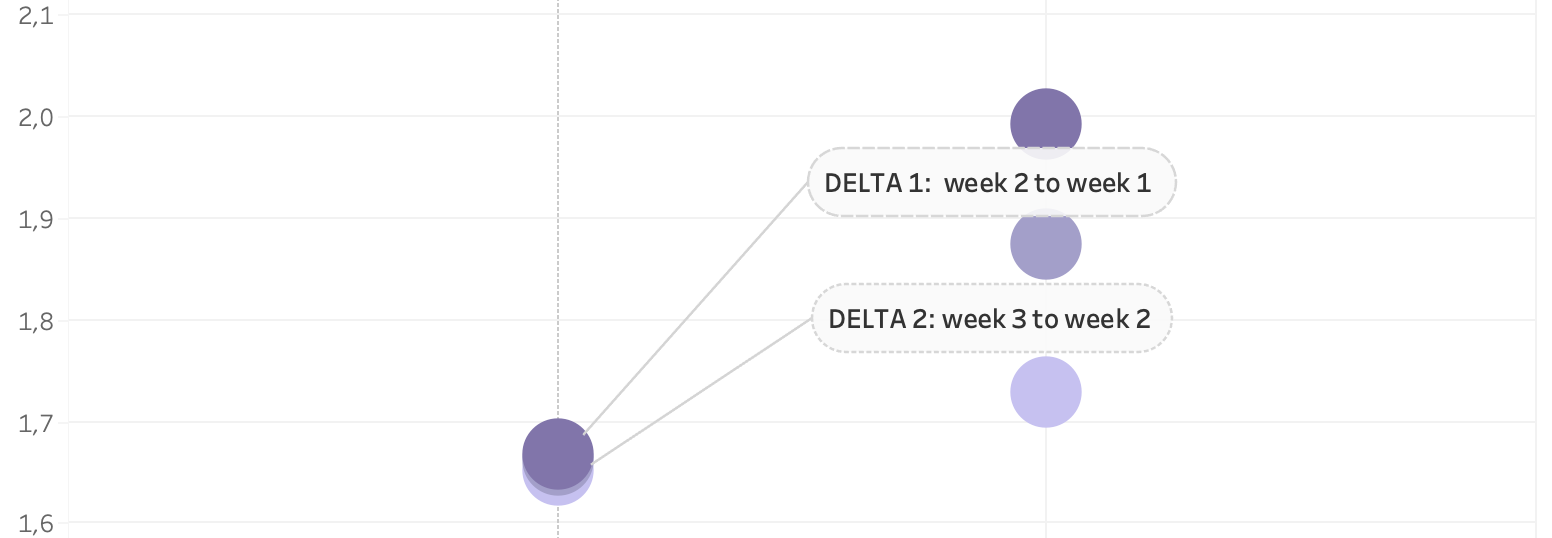
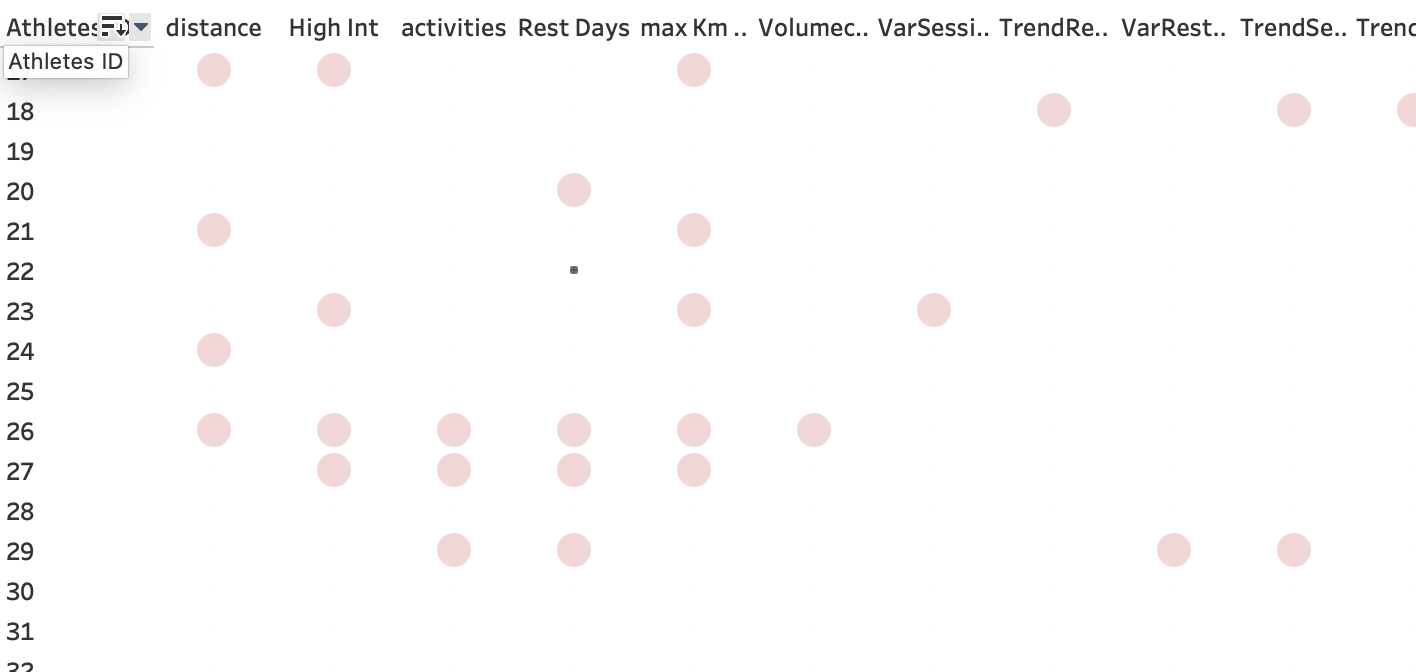
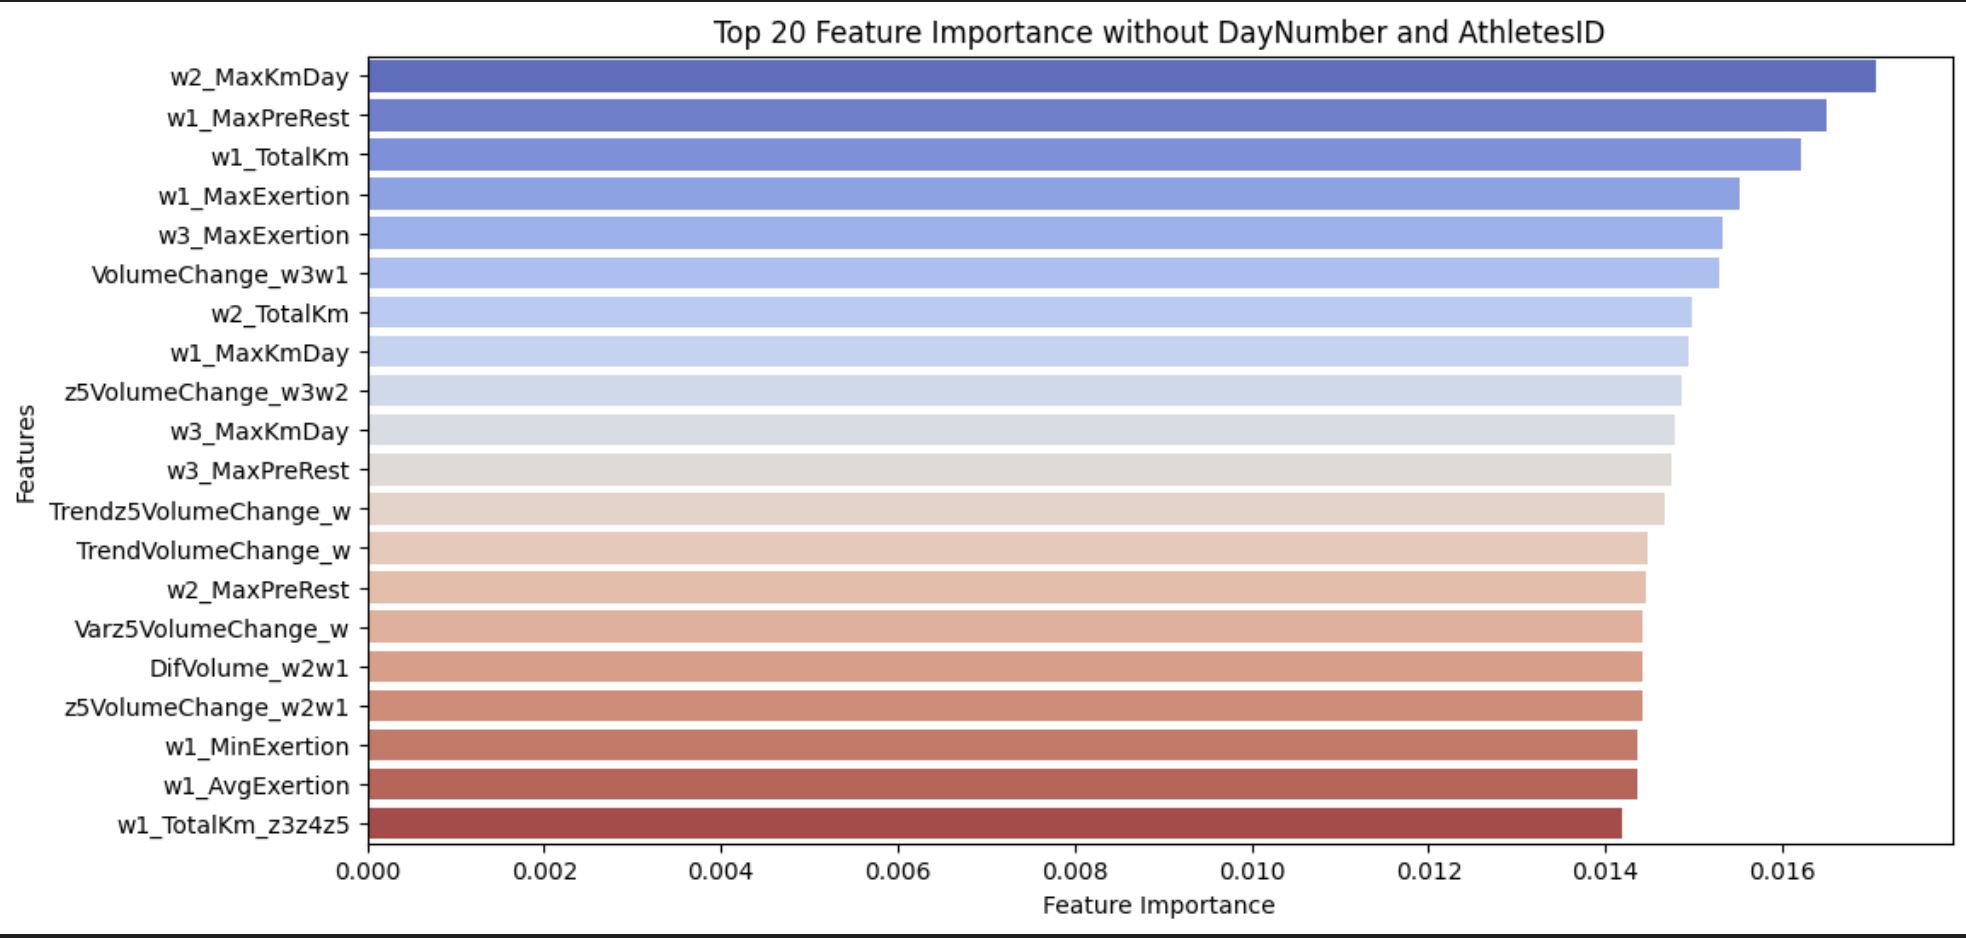

-------------------------------

In [75]:
## importing relevant packages

# Pandas
import pandas as pd

# Numpy
import numpy as np

# scipy stats
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu
from scipy import stats

# SQALchemy
from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string
from sqlalchemy.exc import SQLAlchemyError
from dotenv import dotenv_values # to load the data from .env file

# logistic regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore",message="MallocStackLogging: can't turn off malloc stack logging")



# 1. loading data

### SQL 

preparing the connection

In [76]:
#load the data from .env file
config = dotenv_values()

# define variables for the login
pg_user = config['AZURE_USER'] 
pg_host = config['AZURE_HOST']
pg_port = config['AZURE_PORT']
pg_db = config['AZURE_DB']
pg_schema = config['AZURE_SCHEMA']
pg_pass = config['AZURE_PASS']

# build the URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

# create the engine
engine = create_engine(url, echo=False)
engine.url

# build the search path
my_schema = pg_schema 
with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))

# testing the connection
def test_db_connection(engine):
    try:
        connection = engine.connect() # including 'connection' as variable to close the connection
        print("Connection successful!")
        connection.close() # closing the connection
        return True
    except SQLAlchemyError as e:
        print(f"Connection failed: {e}")
        return False

# Test the connection
test_db_connection(engine)

Connection successful!


True

reading DataFrames from Database

In [77]:
# weeks

df_inj_weeks = pd.read_sql(sql=text('SELECT * FROM public.df_inj_weeks_clean;'), con=engine)

# days

df_inj_days = pd.read_sql(sql=text('SELECT * FROM public.df_inj_days_clean;'), con=engine)

# 2. building Δ-columns

For heading towards the spaces in between, for the change, for the inconsitency, I need to bring those changes to light by defining new columns.

The perspective is always coming closer to the event:
- MACRO:  w3 -> w2 -> w1
- micro:  d7 -> d6 -> d5 -> d4 -> d3 -> d2 -> d1

## 2.1 Sessions

### 2.1.1  week: variance + trend 

In [78]:
## weekly based I do the combination of variance for the intensity of changing and trend for the direction 

# variance
df_inj_weeks["VarSessions_w"] = df_inj_weeks[["w1_Sessions", "w2_Sessions", "w3_Sessions"]].var(axis=1)

# trend
df_inj_weeks["TrendSessions_w"] = df_inj_weeks["w1_Sessions"]- df_inj_weeks["w3_Sessions"]


### 2.1.2 days: (rolling) variance + trend

In [79]:
## the rolling variance usually shows a window of n days, but as the data is already aggregated to 7 days in one row
## we just use a normal variance code
## for the trend we take the all over view from 7days before to 1 day before the event

# variance
df_inj_days["VarSessions_d"] = df_inj_days[["d1_Sessions", "d2_Sessions", "d3_Sessions", "d4_Sessions", "d5_Sessions", "d6_Sessions", "d7_Sessions"]].var(axis=1)

# trend
df_inj_days["TrendSessions_d"] = df_inj_days["d1_Sessions"] - df_inj_days["d7_Sessions"]


## 2.2 Rest Days

### 2.2.1 week: variance + trend

In [80]:
## RestDays for MACRO perspective

# variance
df_inj_weeks["VarRestDays_w"] = df_inj_weeks[["w1_RestDays", "w2_RestDays", "w3_RestDays"]].var(axis=1)

# trend
df_inj_weeks["TrendRestDays_w"] = df_inj_weeks["w1_RestDays"] - df_inj_weeks["w3_RestDays"]



### 2.2.2 days: (rolling) variance + trend

In [81]:
## RestDays for micro perspective

# variance
df_inj_days["VarRestDays_d"] = df_inj_days[["d1_RestDay", "d2_RestDay", "d3_RestDay", "d4_RestDay", "d5_RestDay", "d6_RestDay", "d7_RestDay"]].var(axis=1)

# trend
df_inj_days["TrendRestDays_d"] = df_inj_days["d1_RestDay"] - df_inj_days["d7_RestDay"]

## 2.3 Strenght Training

### 2.3.1 week: variance + trend

In [82]:
## StrengthTraining for MACRO perspective

# variance
df_inj_weeks["VarStrengthTraining_w"] = df_inj_weeks[["w1_StrengthTrainings", "w2_StrengthTrainings", "w3_StrengthTrainings"]].var(axis=1)

# trend
df_inj_weeks["TrendStrengthTraining_w"] = df_inj_weeks["w1_StrengthTrainings"] - df_inj_weeks["w3_StrengthTrainings"]

### 2.3.2 days: (rolling) variance + trend

In [83]:
## StrengthTraining for micro perspective

# variance
df_inj_days["VarStrengthTraining_d"] = df_inj_days[["d1_StrengthTraining", "d2_StrengthTraining", "d3_StrengthTraining", "d4_StrengthTraining", "d5_StrengthTraining", "d6_StrengthTraining", "d7_StrengthTraining"]].var(axis=1)

# trend
df_inj_days["TrendStrengthTraining_d"] = df_inj_days["d1_StrengthTraining"] - df_inj_days["d7_StrengthTraining"]


## 2.4 Total Km

### 2.4.1 weeks: log.rel + variance + trend 

I choose the logarithmic relation because the TotalKm varies from 0 to 235km. 
Logarithmic transformation helps better capture the percentage difference between values, especially when there are large differences in the data. It helps reduce extreme values ​​and amplify smaller changes.

In [84]:
## the VolumeChange in Macro perspective was already changed to logarithmic relation during cleaning. 
## so now I only add the variance and trend

# variance
df_inj_weeks["VarVolumeChange_w"] = df_inj_weeks[["VolumeChange_w2w1", "VolumeChange_w3w2"]].var(axis=1)

# trend
df_inj_weeks["TrendVolumeChange_w"] = df_inj_weeks["w1_TotalKm"] - df_inj_weeks["w3_TotalKm"]


### 2.4.2  days: log.rel + variance + trend 

In [85]:
## for the micro perspective I have to add columns for the logarithmic relational VolumeChange.

# calculating ln(1+x) to be prepared for very small numbers of TotalKm
log_columns = ['d1_TotalKm', 'd2_TotalKm', 'd3_TotalKm', 'd4_TotalKm', 'd5_TotalKm', 'd6_TotalKm', 'd7_TotalKm']
df_log = df_inj_days[log_columns].apply(np.log1p)

# Calculating logartihmic relations of day by day following
log_rel = pd.DataFrame()
for i in range(1, len(df_log.columns)):
    log_rel[f'VolumeChange_d{i+1}d{i}'] = df_log.iloc[:, i-1] - df_log.iloc[:, i]

# concat the new columns to df_inj_days
df_inj_days = pd.concat([df_inj_days, log_rel], axis=1)

In [86]:
## now I can add variance and trend

# variance
df_inj_days["VarVolumeChange_d"] = df_inj_days[["VolumeChange_d7d6", "VolumeChange_d6d5", "VolumeChange_d5d4", "VolumeChange_d4d3", "VolumeChange_d3d2", "VolumeChange_d2d1"]].var(axis=1)

# trend
df_inj_days["TrendVolumeChange_d"] = df_inj_days["d1_TotalKm"] - df_inj_days["d7_TotalKm"]


## 2.5 high intensity KmZ5

### 2.5.1 week: log.rel + variance + trend 

according to the TotalKm, I also calculate the log.rel for the km in the Heartrate Zone 5

In [87]:
## logarithmic relation for z5 MACRO perspective

# calculating ln(1+x) 
log_columns = ['w1_TotalKm_z5', 'w2_TotalKm_z5', 'w3_TotalKm_z5']
df_log = df_inj_weeks[log_columns].apply(np.log1p)

# Calculating logartihmic relations of day by day following
log_rel = pd.DataFrame()
for i in range(1, len(df_log.columns)):
    log_rel[f'z5VolumeChange_w{i+1}w{i}'] = df_log.iloc[:, i-1] - df_log.iloc[:, i]

# concat the new columns to df_inj_days
df_inj_weeks = pd.concat([df_inj_weeks, log_rel], axis=1)

In [88]:
## variance and trend for z5VolumeChange MACRO perspective

# variance
df_inj_weeks["Varz5VolumeChange_w"] = df_inj_weeks[["z5VolumeChange_w2w1", "z5VolumeChange_w3w2"]].var(axis=1)

# trend
df_inj_weeks["Trendz5VolumeChange_w"] = df_inj_weeks["w1_TotalKm_z5"] - df_inj_weeks["w3_TotalKm_z5"]


### 2.5.2 days: log.rel + variance + trend 

In [89]:
## logarithmic relation for z5 micro perspective

# calculating ln(1+x) 
log_columns = ['d1_KmZ5', 'd2_KmZ5', 'd3_KmZ5', 'd4_KmZ5', 'd5_KmZ5', 'd6_KmZ5', 'd7_KmZ5']
df_log = df_inj_days[log_columns].apply(np.log1p)

# Calculating logartihmic relations of day by day following
log_rel = pd.DataFrame()
for i in range(1, len(df_log.columns)):
    log_rel[f'z5VolumeChange_d{i+1}d{i}'] = df_log.iloc[:, i-1] - df_log.iloc[:, i]

# concat the new columns to df_inj_days
df_inj_days = pd.concat([df_inj_days, log_rel], axis=1)

In [90]:
## now I can add variance and trend

# variance
df_inj_days["Varz5VolumeChange_d"] = df_inj_days[["z5VolumeChange_d7d6", "z5VolumeChange_d6d5", "z5VolumeChange_d5d4", "z5VolumeChange_d4d3", "z5VolumeChange_d3d2", "z5VolumeChange_d2d1"]].var(axis=1)

# trend
df_inj_days["Trendz5VolumeChange_d"] = df_inj_days["d1_KmZ5"] - df_inj_days["d7_KmZ5"]


# 2.6 export data (to azure)

In [91]:
# MACRO perspective injury = df_inj_train_weeks
#df_inj_weeks.to_sql('df_inj_train_weeks', con=engine, schema='public', if_exists='replace', index=False, chunksize=1000, method='multi')


# micro perspective injury = df_inj_train_days
#df_inj_days.to_sql('df_inj_train_days', con=engine, schema='public', if_exists='replace', index=False, chunksize=1000, method='multi')

# 3. signifcance  Δ-columns

what about the significance of these new  Δ-columns or differently asked: has a change of consistency a potential to predict injuries?

In [92]:
## preparing the two groups for weeks and days

# weeks
df_w_injury_0 = df_inj_weeks[df_inj_weeks["Injury"] == 0]
df_w_injury_1 = df_inj_weeks[df_inj_weeks["Injury"] == 1]

# days
df_d_injury_0 = df_inj_days[df_inj_days["Injury"] == 0]
df_d_injury_1 = df_inj_days[df_inj_days["Injury"] == 1]

In [98]:
## grouping the delta-columns to variables - changed to two groups each, because the result of distribution is differently

# weeks
w_Delta = [ 'VarSessions_w', 
            'TrendSessions_w',

            'VarRestDays_w', 
            'TrendRestDays_w',

            #'VarStrengthTraining_w', 
            #'TrendStrengthTraining_w',
                        
            'VarVolumeChange_w', 
            'TrendVolumeChange_w',
            'VolumeChange_w2w1', 
            'VolumeChange_w3w1', 
            'VolumeChange_w3w2', 

            'Trendz5VolumeChange_w'
            ]

w_Delta_norm = [ 
            'Varz5VolumeChange_w',
            'z5VolumeChange_w2w1', 
            'z5VolumeChange_w3w2'
              ]

# days
d_Delta = [ 'VarSessions_d',
            'TrendSessions_d',

            'VarRestDays_d',
            'TrendRestDays_d',

            'VarVolumeChange_d',
            'TrendVolumeChange_d',
            #'VolumeChange_d2d1',
            #'VolumeChange_d3d2',
            #'VolumeChange_d4d3',
            #'VolumeChange_d5d4',
            #'VolumeChange_d6d5',
            #'VolumeChange_d7d6',

            'Varz5VolumeChange_d',
            'Trendz5VolumeChange_d',
            #'z5VolumeChange_d2d1',
            #'z5VolumeChange_d3d2',
            #'z5VolumeChange_d4d3',
            #'z5VolumeChange_d5d4',
            #'z5VolumeChange_d6d5',
            #'z5VolumeChange_d7d6'
            ]

#### 3.1.1 weeks: distribution testing

In [94]:
# check distribution - weeks

print("🔬 Testing normal distribution (D’Agostino-Pearson-Test):\n")
for week in w_Delta:
    stat, p_value = normaltest(df_inj_weeks[week])
    if p_value < 0.05:
        result = "❌ NO normal distribution"
    else:
        result = "✅ normal distribution"
    
    print(f"{week}: K²={stat:.3f}, p={p_value:.5f} → {result}")


for week in w_Delta_norm:
    stat, p_value = normaltest(df_inj_weeks[week])
    if p_value < 0.05:
        result = "❌ NO normal distribution"
    else:
        result = "✅ normal distribution"
    
    print(f"{week}: K²={stat:.3f}, p={p_value:.5f} → {result}")


🔬 Testing normal distribution (D’Agostino-Pearson-Test):

VarSessions_w: K²=31107.689, p=0.00000 → ❌ NO normal distribution
TrendSessions_w: K²=1243.061, p=0.00000 → ❌ NO normal distribution
VarRestDays_w: K²=28914.786, p=0.00000 → ❌ NO normal distribution
TrendRestDays_w: K²=2002.458, p=0.00000 → ❌ NO normal distribution
VarVolumeChange_w: K²=56954.374, p=0.00000 → ❌ NO normal distribution
TrendVolumeChange_w: K²=3661.141, p=0.00000 → ❌ NO normal distribution
VolumeChange_w2w1: K²=8243.946, p=0.00000 → ❌ NO normal distribution
VolumeChange_w3w1: K²=6179.756, p=0.00000 → ❌ NO normal distribution
VolumeChange_w3w2: K²=7803.325, p=0.00000 → ❌ NO normal distribution
Trendz5VolumeChange_w: K²=5699.270, p=0.00000 → ❌ NO normal distribution
Varz5VolumeChange_w: K²=29683.328, p=0.00000 → ❌ NO normal distribution
z5VolumeChange_w2w1: K²=1728.213, p=0.00000 → ❌ NO normal distribution
z5VolumeChange_w3w2: K²=1763.255, p=0.00000 → ❌ NO normal distribution


#### 3.1.2 weeks: significance of change

In [95]:
## NOT NORMAL DISTRIBUTED: checking with Mann Whitney U test weeks

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for week in w_Delta:
    stat, p_value = mannwhitneyu(df_w_injury_0[week], df_w_injury_1[week], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{week}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

VarSessions_w: U=11907151.500, ❌ not significant (p=0.42572)
TrendSessions_w: U=11223548.000, ✅ significant (p=0.00163)
VarRestDays_w: U=12318949.500, ❌ not significant (p=0.53580)
TrendRestDays_w: U=13061442.500, ✅ significant (p=0.00129)
VarVolumeChange_w: U=11840512.500, ❌ not significant (p=0.31014)
TrendVolumeChange_w: U=11080764.500, ✅ significant (p=0.00032)
VolumeChange_w2w1: U=12051385.000, ❌ not significant (p=0.76553)
VolumeChange_w3w1: U=11111414.500, ✅ significant (p=0.00048)
VolumeChange_w3w2: U=11139010.500, ✅ significant (p=0.00067)
Trendz5VolumeChange_w: U=11296949.500, ✅ significant (p=0.00326)


In [96]:
## NORMAL DISTRIBUTED: checking with T-test

print("🔬 T-Test (parametric Test for normal distribution):\n")
for week in w_Delta_norm:
    # Check, ob die Spalte existiert
    if week in df_w_injury_0.columns and week in df_w_injury_1.columns:
        # NaN-Werte entfernen
        group_0 = df_w_injury_0[week].dropna()
        group_1 = df_w_injury_1[week].dropna()
        
        # Sicherstellen, dass jede Gruppe mehr als eine eindeutige Zahl hat
        if group_0.nunique() > 1 and group_1.nunique() > 1:
            t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)

            # Ergebnis interpretieren
            if p_value < 0.05:
                print(f"'{week}' - ✅ significantly different (p-value: {p_value:.4f})")
            else:
                print(f"'{week}' - ❌ NO significant difference (p-value: {p_value:.4f})")
        else:
            print(f"⚠️ '{week}' hat in einer Gruppe nur einen Wert → t-Test nicht möglich.")
    else:
        print(f"⚠️ '{week}' nicht in den DataFrames gefunden!")


🔬 T-Test (parametric Test for normal distribution):

'Varz5VolumeChange_w' - ❌ NO significant difference (p-value: 0.0769)
'z5VolumeChange_w2w1' - ❌ NO significant difference (p-value: 0.0690)
'z5VolumeChange_w3w2' - ❌ NO significant difference (p-value: 0.0917)


#### 3.2.1 days: distribution testing

In [100]:
# check distribution - days

print("🔬 Testing normal distribution (D’Agostino-Pearson-Test):\n")
for day in d_Delta:
    stat, p_value = normaltest(df_inj_days[day])
    if p_value < 0.05:
        result = "❌ NO normal distribution"
    else:
        result = "✅ normal distribution"
    
    print(f"{day}: K²={stat:.3f}, p={p_value:.5f} → {result}")




🔬 Testing normal distribution (D’Agostino-Pearson-Test):

VarSessions_d: K²=4970.615, p=0.00000 → ❌ NO normal distribution
TrendSessions_d: K²=56.375, p=0.00000 → ❌ NO normal distribution
VarRestDays_d: K²=792232.729, p=0.00000 → ❌ NO normal distribution
TrendRestDays_d: K²=79.581, p=0.00000 → ❌ NO normal distribution
VarVolumeChange_d: K²=1450.627, p=0.00000 → ❌ NO normal distribution
TrendVolumeChange_d: K²=1433.262, p=0.00000 → ❌ NO normal distribution
Varz5VolumeChange_d: K²=12136.859, p=0.00000 → ❌ NO normal distribution
Trendz5VolumeChange_d: K²=9580.214, p=0.00000 → ❌ NO normal distribution


#### 3.2.2 days: sginificance of change

In [101]:
## NOT NORMAL DISTRIBUTED: checking with Mann Whitney U test - days

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for day in d_Delta:
    stat, p_value = mannwhitneyu(df_d_injury_0[day], df_d_injury_1[day], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{day}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

VarSessions_d: U=12006858.500, ❌ not significant (p=0.32452)
TrendSessions_d: U=12369986.500, ❌ not significant (p=0.78109)
VarRestDays_d: U=12624653.500, ❌ not significant (p=0.25927)
TrendRestDays_d: U=12440213.000, ❌ not significant (p=0.55058)
VarVolumeChange_d: U=10567128.000, ✅ significant (p=0.00000)
TrendVolumeChange_d: U=13190510.500, ✅ significant (p=0.00240)
Varz5VolumeChange_d: U=10670767.000, ✅ significant (p=0.00000)
Trendz5VolumeChange_d: U=12782959.000, ✅ significant (p=0.03106)


# 4. correlation Δ-columns

By printing the heatmap for the new  Δ-columns and the VolumeChange columns that we filled differently then in the paper, let's see if we can have significant correlations

### 4.1 heatmap - weeks (MACRO)

In [104]:
# MACRO perspective for delta-columns

correlation_matrix_w = df_inj_weeks[['Injury', 
                        'VarSessions_w', 
                        'TrendSessions_w',

                        'VarRestDays_w', 
                        'TrendRestDays_w',

                        'VarStrengthTraining_w', 
                        'TrendStrengthTraining_w',
                        
                        'VarVolumeChange_w', 
                        'TrendVolumeChange_w',
                        'VolumeChange_w2w1', 
                        'VolumeChange_w3w1', 
                        'VolumeChange_w3w2', 

                        'Varz5VolumeChange_w', 
                        'Trendz5VolumeChange_w', 
                        'z5VolumeChange_w2w1', 
                        'z5VolumeChange_w3w2' 
                        ]].corr()


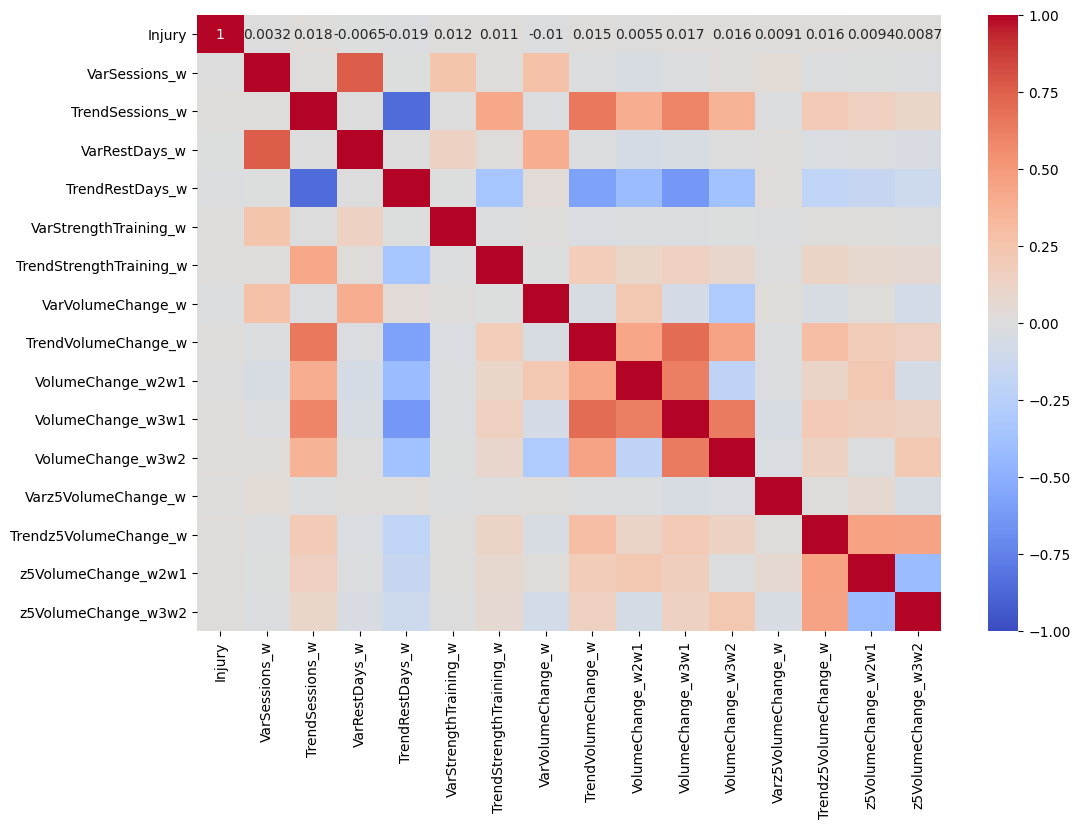

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_w, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [106]:
# print the correlation to Injury

column_name = 'Injury'

for col in correlation_matrix_w.columns:
    if col != column_name:  # Skip 'Injury' itself
        injury_corr = correlation_matrix_w.at[col, column_name]  # Get correlation value
        abs_corr = abs(injury_corr)

        # Determine correlation strength category
        if abs_corr < 0.1:
            description = "❌ No significant correlation"
        elif abs_corr < 0.3:
            description = "Low correlation"
        elif abs_corr < 0.5:
            description = "Medium correlation"
        elif abs_corr < 0.7:
            description = "High correlation"
        elif abs_corr < 0.9:
            description = "Very high correlation"
        elif abs_corr < 1.0:
            description = "Nearly perfect correlation"
        else:
            description = "Perfect correlation"

        print(f"{col}: {description} ({injury_corr:.5f})")



VarSessions_w: ❌ No significant correlation (0.00316)
TrendSessions_w: ❌ No significant correlation (0.01844)
VarRestDays_w: ❌ No significant correlation (-0.00647)
TrendRestDays_w: ❌ No significant correlation (-0.01941)
VarStrengthTraining_w: ❌ No significant correlation (0.01161)
TrendStrengthTraining_w: ❌ No significant correlation (0.01146)
VarVolumeChange_w: ❌ No significant correlation (-0.01002)
TrendVolumeChange_w: ❌ No significant correlation (0.01524)
VolumeChange_w2w1: ❌ No significant correlation (0.00554)
VolumeChange_w3w1: ❌ No significant correlation (0.01748)
VolumeChange_w3w2: ❌ No significant correlation (0.01641)
Varz5VolumeChange_w: ❌ No significant correlation (0.00906)
Trendz5VolumeChange_w: ❌ No significant correlation (0.01591)
z5VolumeChange_w2w1: ❌ No significant correlation (0.00936)
z5VolumeChange_w3w2: ❌ No significant correlation (0.00874)


### 4.2 heatmap - days (micro)

In [107]:
# micro perspective for delta-columns

correlation_matrix_d = df_inj_days[['Injury', 
                    'VarSessions_d',
                    'TrendSessions_d',

                    'VarRestDays_d',
                    'TrendRestDays_d',

                    'VarVolumeChange_d',
                    'TrendVolumeChange_d',
                    'VolumeChange_d2d1',
                    'VolumeChange_d3d2',
                    'VolumeChange_d4d3',
                    'VolumeChange_d5d4',
                    'VolumeChange_d6d5',
                    'VolumeChange_d7d6',

                    'Varz5VolumeChange_d',
                    'Trendz5VolumeChange_d',
                    'z5VolumeChange_d2d1',
                    'z5VolumeChange_d3d2',
                    'z5VolumeChange_d4d3',
                    'z5VolumeChange_d5d4',
                    'z5VolumeChange_d6d5',
                    'z5VolumeChange_d7d6'
                    ]].corr()


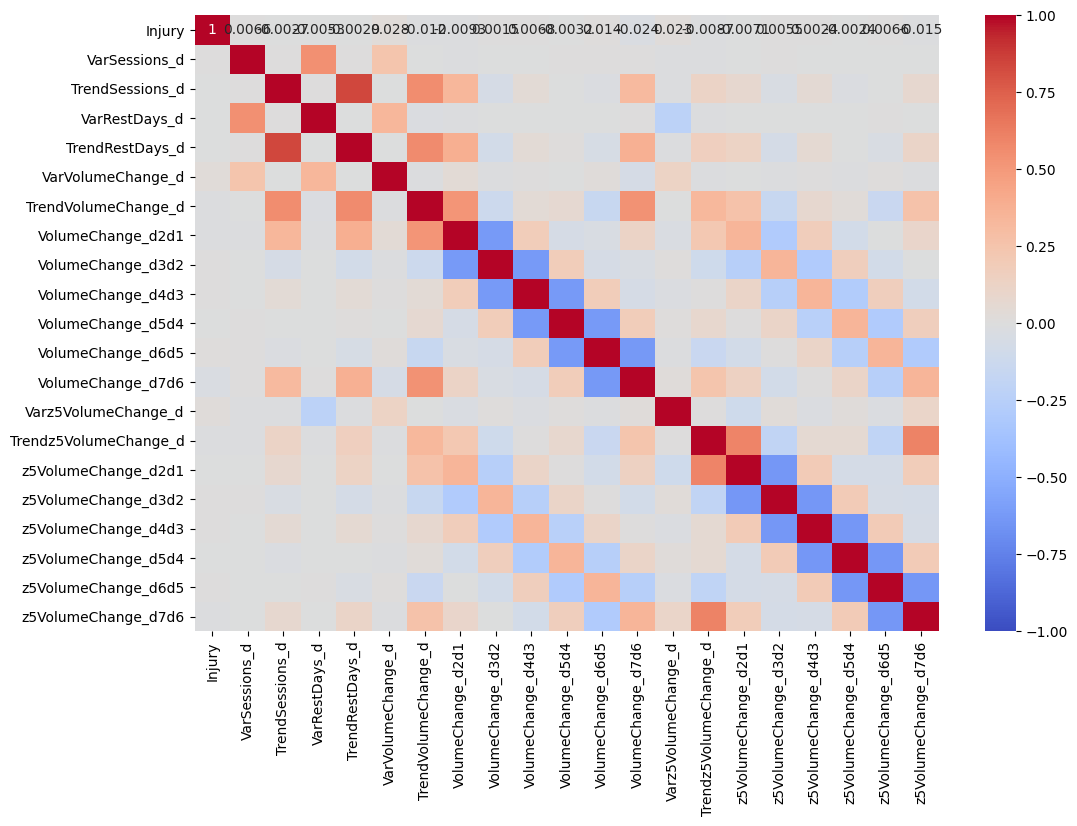

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_d, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [109]:
# print the correlation to Injury

column_name = 'Injury'

for col in correlation_matrix_d.columns:
    if col != column_name:  # Skip 'Injury' itself
        injury_corr = correlation_matrix_d.at[col, column_name]  # Get correlation value
        abs_corr = abs(injury_corr)

        # Determine correlation strength category
        if abs_corr < 0.1:
            description = "❌ No significant correlation"
        elif abs_corr < 0.3:
            description = "Low correlation"
        elif abs_corr < 0.5:
            description = "Medium correlation"
        elif abs_corr < 0.7:
            description = "High correlation"
        elif abs_corr < 0.9:
            description = "Very high correlation"
        elif abs_corr < 1.0:
            description = "Nearly perfect correlation"
        else:
            description = "Perfect correlation"

        print(f"{col}: {description} ({injury_corr:.5f})")



VarSessions_d: ❌ No significant correlation (0.00656)
TrendSessions_d: ❌ No significant correlation (-0.00268)
VarRestDays_d: ❌ No significant correlation (-0.00532)
TrendRestDays_d: ❌ No significant correlation (-0.00289)
VarVolumeChange_d: ❌ No significant correlation (0.02843)
TrendVolumeChange_d: ❌ No significant correlation (-0.01241)
VolumeChange_d2d1: ❌ No significant correlation (-0.00932)
VolumeChange_d3d2: ❌ No significant correlation (0.00154)
VolumeChange_d4d3: ❌ No significant correlation (0.00680)
VolumeChange_d5d4: ❌ No significant correlation (-0.00325)
VolumeChange_d6d5: ❌ No significant correlation (0.01401)
VolumeChange_d7d6: ❌ No significant correlation (-0.02430)
Varz5VolumeChange_d: ❌ No significant correlation (0.02318)
Trendz5VolumeChange_d: ❌ No significant correlation (-0.00873)
z5VolumeChange_d2d1: ❌ No significant correlation (-0.00713)
z5VolumeChange_d3d2: ❌ No significant correlation (0.00551)
z5VolumeChange_d4d3: ❌ No significant correlation (0.00241)
z5V

## 4.3 result: no correlation

Also the new features don't show any correlation

-----------------------

# 5. Machine Learning Models

## 5.1 Logistic Regression training and evaluating

Now that I entered all Δ-columns I wanted, I will now try the chosen models.

1. seperate the target variable ('Injury') from the independant variables
2. splitting groups 80% training / 20% testing
3. Polynomial Features combine the columns, the degree says how many to combine(2 in this case)
4. building the Pipeline with LogisticRegression as classifier
5. train the model (.fit)
6. predict with the test-group y (.predict)

Interpretation of the results:
- 🔹 Accuracy: Proportion of correctly predicted values
- 🔹 Precision: How many of the predicted injury=1 were actually correct?
- 🔹 Recall: How many of the actual injuries=1 were detected?
- 🔹 F1-Score: Harmonic Mean from Precision & Recall (good for unbalanced data)
- 🔹 Confusion Matrix: Indicates how many 0s and 1s were classified correctly and incorrectly

### 5.1.1 weeks

#### preparing variables - MACRO perspective

In [110]:
## for training the model, seperate the target variable and group randomly as two groups (train & test) out of the data

# independant variables (features) and target (injury)
X = df_inj_weeks.drop(columns=["Injury"])  
y = df_inj_weeks["Injury"]  

# splitting 80% Training and 20% Test - stratify so that injury relation in both sets is equal 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#### running model - MACRO perspective

In [111]:
## train the model

# Polynomiale Features up to degree 2 and interactions
poly = PolynomialFeatures(degree=2, interaction_only=True)

# first Standardscaller (km 0 to 235, days 0 to 14), than Pipeline with polynomial Features + logistic regression
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", poly),
    ("classifier", LogisticRegression(solver='liblinear'))
])

# training Model
logreg.fit(X_train, y_train)

# Prediction on test group
y_pred = logreg.predict(X_test)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [112]:
## interpret the data

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

# precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.983
Precision: 0.163
Recall: 0.061
F1-Score: 0.089
Confusion Matrix:
[[8409   36]
 [ 108    7]]


The results are sobering - before trying another model, I will check without standardscaler (also started checking with degree=3 but the Kernel crashed, so I decided to drop that, as I will check more complex combination with the random forest)

In [113]:
# Polynomiale Features up to degree 2 and interactions
poly = PolynomialFeatures(degree=2, interaction_only=True)

# Pipeline with polynomial Features + logistic regression (no StandardScaler)
logreg = Pipeline([
    ("poly_features", poly),
    ("classifier", LogisticRegression(solver='liblinear'))
])

# training Model
logreg.fit(X_train, y_train)

# Prediction on test group
y_pred = logreg.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

# precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.986
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Confusion Matrix:
[[8444    1]
 [ 115    0]]


### 5.1.2 days

#### preparing variables - micro perspective

In [114]:
## for training the model, seperate the target variable and group randomly as two groups (train & test) out of the data

# independant variables (features) and target (injury)
X = df_inj_days.drop(columns=["Injury"])  
y = df_inj_days["Injury"]  

# splitting 80% Training and 20% Test - stratify so that injury relation in both sets is equal 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#### running model - micro perspective

In [115]:
## train the model

# Polynomiale Features up to degree 2 and interactions
poly = PolynomialFeatures(degree=2, interaction_only=True)

# first Standardscaller (km 0 to 235, days 0 to 14), than Pipeline with polynomial Features + logistic regression
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", poly),
    ("classifier", LogisticRegression(solver='liblinear'))
])

# training Model
logreg.fit(X_train, y_train)

# Prediction on test group
y_pred = logreg.predict(X_test)

## interpret the data

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

# precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.963
Precision: 0.023
Recall: 0.043
F1-Score: 0.030
Confusion Matrix:
[[8229  208]
 [ 112    5]]


### 5.1.3 conclusion
Neither for MACRO nor for micro perspective the Logistic Regression Modell comes with suffisantly relyable prediction.

----

## 5.2 Random Forest

### 5.2.1 features for random forest

In [116]:
# make sure not to have any NaN or infinite values

nan_cols = X.columns[X.isna().any()]
print(nan_cols)
inf_cols = X.columns[(X == np.inf).any() | (X == -np.inf).any()]
print(inf_cols)

Index([], dtype='object')
Index([], dtype='object')


In [117]:
## random forest

from sklearn.ensemble import RandomForestClassifier

X = df_inj_weeks.drop(columns=["Injury"])
y = df_inj_weeks["Injury"]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)


DayNumber                  0.044499
AthletesID                 0.017306
w2_MaxKmDay                0.017065
w1_MaxPreRest              0.016504
w1_TotalKm                 0.016204
                             ...   
w1_DaysIntervalSessions    0.005138
w3_StrengthTrainings       0.005076
w3_ToughSessions_z5        0.005039
w2_DaysIntervalSessions    0.004770
w2_ToughSessions_z5        0.004454
Length: 86, dtype: float64


DayNumber                  0.044499
AthletesID                 0.017306
w2_MaxKmDay                0.017065
w1_MaxPreRest              0.016504
w1_TotalKm                 0.016204
                             ...   
w1_DaysIntervalSessions    0.005138
w3_StrengthTrainings       0.005076
w3_ToughSessions_z5        0.005039
w2_DaysIntervalSessions    0.004770
w2_ToughSessions_z5        0.004454
Length: 86, dtype: float64


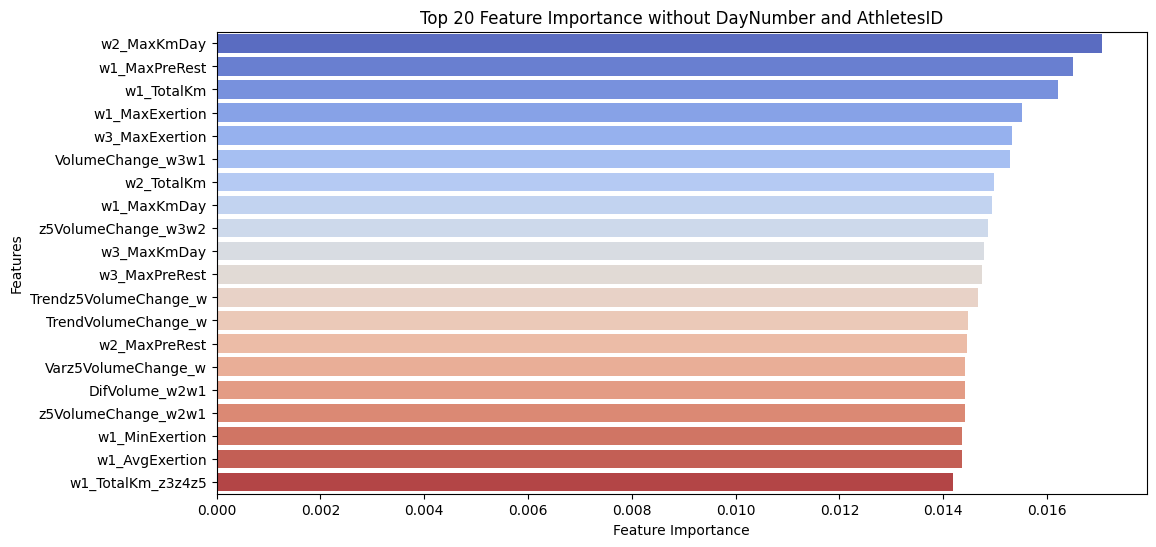

In [118]:
## viualise Feature Importance - week

feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)

# exclude DayNumber and AthletesID
filtered_importance = feature_importance.drop(['DayNumber', 'AthletesID'], errors='ignore')

# sort and plot
filtered_importance = filtered_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=filtered_importance.values, y=filtered_importance.index, palette="coolwarm")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importance without DayNumber and AthletesID")
plt.show()


DayNumber              0.044369
VarVolumeChange_d      0.024961
VolumeChange_d5d4      0.022851
AthletesID             0.021977
VolumeChange_d7d6      0.021343
VolumeChange_d6d5      0.020957
VolumeChange_d2d1      0.020489
VolumeChange_d4d3      0.020379
VolumeChange_d3d2      0.019720
d5_Exertion            0.018727
d5_PreRest             0.018625
d2_PreRest             0.017924
d4_Exertion            0.017633
d1_PreRest             0.017533
d7_Exertion            0.017461
TrendVolumeChange_d    0.017208
d3_PreRest             0.017052
d7_PreRest             0.016717
d1_Exertion            0.016685
d3_Exertion            0.016661
dtype: float64


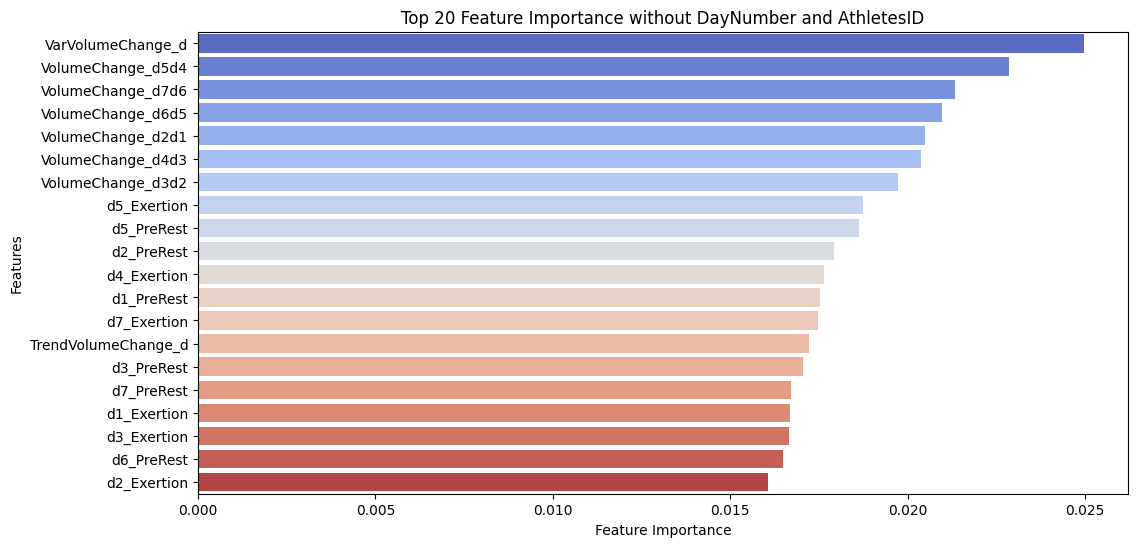

In [119]:
## viualise Feature Importance - day

X = df_inj_days.drop(columns=["Injury"])
y = df_inj_days["Injury"]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance.head(20))

import matplotlib.pyplot as plt

# Entferne DayNumber und AthletesID aus der Feature Importance Analyse
filtered_importance = feature_importance.drop(['DayNumber', 'AthletesID'], errors='ignore')

# Sortieren und visualisieren
filtered_importance = filtered_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=filtered_importance.values, y=filtered_importance.index, palette="coolwarm")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importance without DayNumber and AthletesID")
plt.show()

In [120]:

nan_cols = X.columns[X.isna().any()]
print(nan_cols)
inf_cols = X.columns[(X == np.inf).any() | (X == -np.inf).any()]
print(inf_cols)



Index([], dtype='object')
Index([], dtype='object')


---

### 5.2.2 run model random forest

In [121]:


# Daten vorbereiten (Features und Zielvariablen)
X = df_inj_weeks.drop('Injury', axis=1)  # Deine Features (ohne die Zielvariable 'injury')
y = df_inj_weeks['Injury']  # Zielvariable

# Train-Test Split (z.B. 80% Training und 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# StandardScaler verwenden (optional, wenn du den Einfluss von unterschiedlichen Maßstäben der Features minimieren möchtest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Modell erstellen
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Trainieren
rf.fit(X_train, y_train)

# Vorhersagen
y_pred_rf = rf.predict(X_test)

# Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.3f}")

# Weitere Metriken
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest Precision: {precision_rf:.3f}")
print(f"Random Forest Recall: {recall_rf:.3f}")
print(f"Random Forest F1-Score: {f1_rf:.3f}")


Random Forest Accuracy: 0.988
Random Forest Precision: 0.000
Random Forest Recall: 0.000
Random Forest F1-Score: 0.000


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [122]:
# !pip install imbalanced-learn

In [123]:
## AthletesID und DayNumber ausklammern sowie nur Features mit Importance > 0.01 / mit balanced wegen sample size injury 1

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# 1. AthletesID und DayNumber aus den Features entfernen
X = df_inj_days.drop(columns=['AthletesID', 'DayNumber', 'Injury'])

# Zielvariable (Injury) definieren
y = df_inj_days['Injury']

# 2. Random Forest Modell trainieren, um Feature Importances zu bestimmen - class_weight balanced um das ungleichgewicht von inj 0 und 1 auszugleichen
rf = RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X, y)

# 3. Nur Features mit Importance > 0.01 auswählen
important_features = X.columns[rf.feature_importances_ > 0.01]

# 4. Trainings- und Testdaten aufteilen mit den ausgewählten Features
X_selected = X[important_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Modell trainieren
rf.fit(X_train, y_train)

# Vorhersagen auf den Testdaten machen
y_pred = rf.predict(X_test)

# Ergebnisse anzeigen
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8437
           1       0.00      0.00      0.00       117

    accuracy                           0.99      8554
   macro avg       0.49      0.50      0.50      8554
weighted avg       0.97      0.99      0.98      8554



/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [124]:
## mit oversampling und balanced

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# 1. X und y vorbereiten
X = df_inj_days.drop(columns=['AthletesID', 'DayNumber', 'Injury'])
y = df_inj_days['Injury']

# 2. Train-Test-Split mit Stratification (um die Verteilung der Klassen zu bewahren)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. SMOTE auf den Trainingsdaten anwenden
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 4. Random Forest Modell erstellen
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# 5. Modell mit den resampleten Trainingsdaten trainieren
model.fit(X_train_res, y_train_res)

# 6. Vorhersage auf den Testdaten
y_pred = model.predict(X_test)

# Optional: Evaluation
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8437
           1       0.00      0.00      0.00       117

    accuracy                           0.99      8554
   macro avg       0.49      0.50      0.50      8554
weighted avg       0.97      0.99      0.98      8554

[[8436    1]
 [ 117    0]]


In [125]:
## combi aus oversampling und undersampling

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train/Test Split
X = df_inj_days.drop(columns=['Injury', 'DayNumber', 'AthletesID'])
y = df_inj_days['Injury']

# Split into train/test with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE for oversampling and RandomUnderSampler for undersampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# First, apply oversampling
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Then, apply undersampling
X_train_res, y_train_res = under_sampler.fit_resample(X_train_res, y_train_res)

# Create the Random Forest Classifier with class_weight='balanced'
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model with the resampled data
clf.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8437
           1       0.00      0.00      0.00       117

    accuracy                           0.99      8554
   macro avg       0.49      0.50      0.50      8554
weighted avg       0.97      0.99      0.98      8554



In [126]:
## die Hyperparameter des Random Forest anpassen

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Angenommen, df_inj_days ist dein DataFrame und "Injury" ist die Zielvariable
X = df_inj_days.drop(columns=['Injury', 'AthletesID', 'DayNumber'])  # Entferne 'Injury', 'AthletesID' und 'DayNumber'
y = df_inj_days['Injury']  # Die Zielvariable (Injury)

# Splitte den DataFrame in Trainings- und Testdaten (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Wende SMOTE an, um das Ungleichgewicht der Klassen auszugleichen
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Definiere die Parameter, die du testen möchtest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialisiere den Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Initialisiere GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_res, y_train_res)

# Beste Parameter anzeigen
print("Beste Parameter:", grid_search.best_params_)

# Modell mit besten Parametern trainieren
best_rf = grid_search.best_estimator_

# Vorhersagen auf dem Testset
y_pred = best_rf.predict(X_test)

# Evaluierung
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

In [ ]:
## weil der code so lang lief, noch mal randonizedSearch statt Grid - dann werden nicht alle kombinationen abgefragt - 
# falls das nicht ausreicht, kann ich am oberen Code aber wie schon geschehen die verteilung auf aller Kernels (n_jobs=-1)
# und ggf die param_dist noch mal ändern


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Angenommen, df_inj_days ist dein DataFrame und "Injury" ist die Zielvariable
X = df_inj_days.drop(columns=['Injury', 'AthletesID', 'DayNumber'])  # Entferne 'Injury', 'AthletesID' und 'DayNumber'
y = df_inj_days['Injury']  # Die Zielvariable (Injury)

# Splitte den DataFrame in Trainings- und Testdaten (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Wende SMOTE an, um das Ungleichgewicht der Klassen auszugleichen
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Jetzt kannst du RandomizedSearchCV verwenden, um die besten Hyperparameter zu finden
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Definiere die Parameter, die du testen möchtest
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1,5),
    'max_features': ['auto', 'sqrt']
}

# Initialisiere den Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Initialisiere RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=param_dist, 
                                   n_iter=20,       # Anzahl der Versuche
                                   cv=3,             # Kreuzvalidierung mit 3 Folds
                                   scoring='accuracy',
                                   n_jobs=-1,        # Nutze alle Kerne
                                   random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_res, y_train_res)

# Beste Parameter anzeigen
print("Beste Parameter:", random_search.best_params_)

# Modell mit besten Parametern trainieren
best_rf = random_search.best_estimator_

# Vorhersagen auf dem Testset
y_pred = best_rf.predict(X_test)

# Evaluierung
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [ ]:
## anpassungen, um evaluation mit balanced accuracy
## smote.sampling_strategy=0.5 (also 50% injury=1)


# Angenommen, df_inj_days ist dein DataFrame und "Injury" ist die Zielvariable
X = df_inj_days.drop(columns=['Injury', 'AthletesID', 'DayNumber'])  # Entferne 'Injury', 'AthletesID' und 'DayNumber'
y = df_inj_days['Injury']  # Die Zielvariable (Injury)

# Splitte den DataFrame in Trainings- und Testdaten (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Wende SMOTE an, um das Ungleichgewicht der Klassen auszugleichen
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Jetzt kannst du RandomizedSearchCV verwenden, um die besten Hyperparameter zu finden
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Definiere die Parameter, die du testen möchtest
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1,5),
    'max_features': ['auto', 'sqrt']
}

# Initialisiere den Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Initialisiere RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=param_dist, 
                                   n_iter=20,       # Anzahl der Versuche
                                   cv=3,             # Kreuzvalidierung mit 3 Folds
                                   scoring='balanced_accuracy',
                                   n_jobs=-1,        # Nutze alle Kerne
                                   random_state=42,
                                   verbose=2)       # zeigt den fortschritt des Hyperparemeter Tuning Prozesses detailliert an

# Fit RandomizedSearchCV
random_search.fit(X_train_res, y_train_res)

# Beste Parameter anzeigen
print("Beste Parameter:", random_search.best_params_)

# Modell mit besten Parametern trainieren
best_rf = random_search.best_estimator_

# Vorhersage der Wahrscheinlichkeiten für beide Klassen (0 und 1)
y_prob = best_rf.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeit für die Klasse '1'

# Definiere einen Schwellenwert (z.B. 0.3)
threshold = 0.3
y_pred_custom = (y_prob > threshold).astype(int)  # Vorhersage auf Basis des Schwellenwerts

# Jetzt kannst du die neuen Vorhersagen auswerten
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))
print(f1_score(y_test, y_pred_custom))

---

# 6. FALL BACK: significance matrix by athlete

Could it be that the differences between the athletes - there are some athletes without any injury and other athletes with 35 injuries - are influencing the significances.

That's why I test them seperatly now - each Athlete on it's own

In [127]:

# Loop over all unique AtletesID
for athlete_id in df_inj_weeks['AthletesID'].unique():
    # group 'normal_week' and group 'pre_injury_week'
    group_0 = df_inj_weeks[(df_inj_weeks['AthletesID'] == athlete_id) & (df_inj_weeks['Injury'] == 0)]
    group_1 = df_inj_weeks[(df_inj_weeks['AthletesID'] == athlete_id) & (df_inj_weeks['Injury'] == 1)]
    
    # check if entries in both groups
    if len(group_0) > 1 and len(group_1) > 1:
        for week in w_Delta_norm:  # Iteration for normaly distributed metrics
            if week in group_0.columns and week in group_1.columns:
                # drop NaN
                group_0_week = group_0[week].dropna()
                group_1_week = group_1[week].dropna()
                
                # check if at least 2 entries per group to use t-test
                if group_0_week.nunique() > 1 and group_1_week.nunique() > 1:
                    # use t-test
                    t_stat, p_value = stats.ttest_ind(group_0_week, group_1_week, equal_var=False)

                    # print results on significance
                    if p_value < 0.05:
                        print(f"Athlete {athlete_id}, metric {week}: ✅ significant (p={p_value:.4f})")
                    else:
                        print(f"Athlete {athlete_id}, metric {week}: ❌ no significant difference (p={p_value:.4f})")
                else:
                    print(f"Athlete {athlete_id}, metric {week}: ⚠️ not enough different values in one of the two groups")
            else:
                print(f"Athlete {athlete_id}, metric {week}: ⚠️ row {week} not included")
    else:
        print(f"Athlete {athlete_id}: ⚠️ one group has less then 2  values, t-Test not possible")


Athlete 0, metric Varz5VolumeChange_w: ❌ no significant difference (p=0.9364)
Athlete 0, metric z5VolumeChange_w2w1: ❌ no significant difference (p=0.7954)
Athlete 0, metric z5VolumeChange_w3w2: ❌ no significant difference (p=0.9235)
Athlete 1, metric Varz5VolumeChange_w: ❌ no significant difference (p=0.4344)
Athlete 1, metric z5VolumeChange_w2w1: ❌ no significant difference (p=0.9576)
Athlete 1, metric z5VolumeChange_w3w2: ❌ no significant difference (p=0.5105)
Athlete 2, metric Varz5VolumeChange_w: ❌ no significant difference (p=0.3959)
Athlete 2, metric z5VolumeChange_w2w1: ❌ no significant difference (p=0.7715)
Athlete 2, metric z5VolumeChange_w3w2: ❌ no significant difference (p=0.8968)
Athlete 3, metric Varz5VolumeChange_w: ✅ significant (p=0.0000)
Athlete 3, metric z5VolumeChange_w2w1: ❌ no significant difference (p=0.2399)
Athlete 3, metric z5VolumeChange_w3w2: ❌ no significant difference (p=0.3676)
Athlete 4, metric Varz5VolumeChange_w: ❌ no significant difference (p=0.3099)


### 4.1 Z-Score manipulation

by normalising the data - regarding that every athlete is individually - aproaching to significances again

In [129]:
from sklearn.preprocessing import StandardScaler

# Spalten, die nicht normalisiert werden sollen
exclude_cols = ['DayNumber', 'AthletesID', 'Injury', 'w1_Sessions', 'w1_RestDays', 'w2_Sessions', 'w2_RestDays', 'w3_Sessions', 'w3_RestDays']

# Alle Spalten, die normalisiert werden sollen (alle numerischen außer den ausgeschlossenen)
feature_cols = [col for col in df_inj_weeks.columns if col not in exclude_cols]

# Spalten mit konstanter Varianz innerhalb jedes Athleten filtern
feature_cols = [col for col in feature_cols if df_inj_weeks.groupby("AthletesID")[col].transform(lambda x: x.nunique() > 1).any()]

# StandardScaler wird pro Athlet angewendet
scaler = StandardScaler()

df_inj_weeks[feature_cols] = df_inj_weeks.groupby('AthletesID')[feature_cols].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten() if x.nunique() > 1 else x
)

df_inj_weeks.head()

,w1_Sessions,w1_RestDays,w1_TotalKm,w1_MaxKmDay,w1_TotalKm_z3z4z5,w1_ToughSessions_z5,w1_DaysIntervalSessions,w1_TotalKm_z3z4,w1_MaxKmDay_z3z4,w1_TotalKm_z5,...,VarRestDays_w,TrendRestDays_w,VarStrengthTraining_w,TrendStrengthTraining_w,VarVolumeChange_w,TrendVolumeChange_w,z5VolumeChange_w2w1,z5VolumeChange_w3w2,Varz5VolumeChange_w,Trendz5VolumeChange_w
0,5.0,2.0,-0.011791,0.735051,1.363580,0.57493,0.540936,1.263190,2.689873,-0.055309,...,0.652561,-1.121765,0.621051,1.825898,-0.218862,0.394858,0.761211,-0.001253,-0.378088,0.332753
1,5.0,2.0,-0.044427,0.735051,1.343819,0.57493,0.540936,1.263190,2.689873,-0.123348,...,-0.136109,-0.563584,0.621051,1.825898,-0.345050,0.006765,-0.089703,0.731392,-0.353302,0.278717
2,5.0,2.0,-0.044427,0.735051,1.343819,0.57493,0.540936,1.263190,2.689873,-0.123348,...,0.652561,-1.121765,4.038667,3.525683,-0.345050,0.006765,-0.089703,0.731392,-0.353302,0.278717
3,5.0,2.0,-0.044427,0.735051,1.343819,0.57493,0.540936,1.263190,2.689873,-0.123348,...,-0.136109,-0.563584,0.621051,1.825898,-0.345050,0.006765,-0.089703,0.731392,-0.353302,0.278717
4,6.0,1.0,0.912885,0.865570,2.766619,0.57493,1.379386,2.725177,2.689873,-0.123348,...,-0.136109,-1.121765,0.621051,1.825898,0.018817,0.687629,-0.089703,0.731392,-0.353302,0.278717


#### build dataframe df_significance

for that include all features divided by it's distribution

In [130]:
w_all = [
 'w1_Sessions',
 'w1_RestDays',
 'w1_TotalKm',
 'w1_MaxKmDay',
 'w1_TotalKm_z5',
 'w2_Sessions',
 'w2_RestDays',
 'w2_TotalKm',
 'w2_MaxKmDay',
 'w2_TotalKm_z5',
 'w3_Sessions',
 'w3_RestDays',
 'w3_TotalKm',
 'w3_MaxKmDay',
 'w3_TotalKm_z5',
 'VolumeChange_w2w1',
 'VolumeChange_w3w1',
 'VolumeChange_w3w2',
 'DifVolume_w2w1',
 'DifVolume_w3w2',
 'DifVolume_w3w1',
 'VarSessions_w',
 'TrendSessions_w',
 'VarRestDays_w',
 'TrendRestDays_w',
 'VarVolumeChange_w',
 'TrendVolumeChange_w',
 'z5VolumeChange_w2w1',
 'z5VolumeChange_w3w2',
 'Varz5VolumeChange_w',
 'Trendz5VolumeChange_w'
 ]

instead of testing the distribution for each feature over the total dataset, I integrate that test into the loop.
So that each feature is tested for distribution devided by athlete and than decide, what test should be used.
I also print the number of testable athletes for this feature after checking, if the two groups (injury=0 or injury=1) are big enough as testable count


In [ ]:
import pandas as pd
from scipy.stats import normaltest, ttest_ind, mannwhitneyu

# Dictionary for keeping the results
results = { "feature": [], "testable": [], "significant": [], "significant_athletes": [] }

# Loop over all features and initializing the values
for week in w_all:
    results["feature"].append(week)
    results["testable"].append(0)
    results["significant"].append(0)
    results["significant_athletes"].append([])  

# Loop over all athletes
for athlete_id in df_inj_weeks['AthletesID'].unique():
    # building two groups (inj=0 and inj=1) for each Athlete
    group_0 = df_inj_weeks[(df_inj_weeks['AthletesID'] == athlete_id) & (df_inj_weeks['Injury'] == 0)]
    group_1 = df_inj_weeks[(df_inj_weeks['AthletesID'] == athlete_id) & (df_inj_weeks['Injury'] == 1)]

    # check if this athlete is at all testable, if the two groups are big enough
    if len(group_0) <= 1 or len(group_1) <= 1:
        continue  

    # Dictionary for choosing test (normal or not normal distributed)
    test_method = {}

    # test distribution for each athlete
    for week in w_all:
        if week in df_inj_weeks.columns:
            data = df_inj_weeks[df_inj_weeks['AthletesID'] == athlete_id][week].dropna()
            
            if len(data) > 7:  # normaltest needs enoug values
                _, p_value = normaltest(data)
                if p_value >= 0.05:
                    test_method[week] = "ttest"  # T-Test for normal distribution
                else:
                    test_method[week] = "mannwhitney"  # Mann-Whitney-U-Test not normal
            else:
                test_method[week] = "mannwhitney"  # in case of not enough values also Mann-Whitney-U

    # testing significance accordingly
    for week, method in test_method.items():
        if week in group_0.columns and week in group_1.columns:
            group_0_week = group_0[week].dropna()
            group_1_week = group_1[week].dropna()

            if group_0_week.nunique() > 1 and group_1_week.nunique() > 1:
                if method == "ttest":
                    _, p_value = ttest_ind(group_0_week, group_1_week, equal_var=False)
                else:
                    _, p_value = mannwhitneyu(group_0_week, group_1_week, alternative='two-sided')

                # set index to count
                idx = w_all.index(week)

                # count testable athletes
                results["testable"][idx] += 1  

                # count significant athletes
                if p_value < 0.05:
                    results["significant"][idx] += 1  
                    results["significant_athletes"][idx].append(athlete_id)  # append AthletesID 

# finale dataframe
df_significance = pd.DataFrame(results)


In [132]:
df_significance.head(1)

,feature,testable,significant,significant_athletes
0,w1_Sessions,53,8,"[26, 27, 29, 42, 47, 56, 58, 68]"


now we can check, if there are athletes for that none of our feature is significant

In [133]:
# all athletes in the main dataset
all_athletes = set(df_inj_weeks['AthletesID'].unique())

# all athletes with signifcances
significant_athletes = set()
for athletes in df_significance["significant_athletes"]:
    if athletes: 
        significant_athletes.update(athletes) 

# AthletesIDs without any significant feature
non_significant_athletes = all_athletes - significant_athletes

print(f"❌ These {len(non_significant_athletes)} Athletes don't have any significant Features: {sorted(non_significant_athletes)}")


❌ These 31 Athletes don't have any significant Features: [5, 6, 9, 11, 12, 13, 15, 16, 25, 28, 30, 31, 34, 37, 39, 44, 45, 46, 48, 49, 50, 51, 52, 55, 60, 62, 63, 66, 70, 72, 73]


### risk factor matrix

for a better visualisation we change the dataframe to be grouped by athlete and shwoing each's personal profil of what factor is significant for each

In [134]:
## variance to plot the injury factor profile matrix

import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Initialisierung des Ergebnisses als leeres Dictionary
significance_matrix = { "AthletesID": df_inj_weeks['AthletesID'].unique() }

# Loop über alle Features
for week in w_all:
    significance_matrix[week] = []  # Spalte für jedes Feature initialisieren
    
    for athlete_id in df_inj_weeks['AthletesID'].unique():
        # Daten des Athleten für den Vergleich
        group_0 = df_inj_weeks[(df_inj_weeks['AthletesID'] == athlete_id) & (df_inj_weeks['Injury'] == 0)]
        group_1 = df_inj_weeks[(df_inj_weeks['AthletesID'] == athlete_id) & (df_inj_weeks['Injury'] == 1)]
        
        if len(group_0) > 1 and len(group_1) > 1:
            # Für jedes Feature im w_all prüfen, ob es normal verteilt ist
            group_0_week = group_0[week].dropna()
            group_1_week = group_1[week].dropna()
            
            # Wenn genug Daten vorhanden sind
            if group_0_week.nunique() > 1 and group_1_week.nunique() > 1:
                # Normalverteilung prüfen mit Shapiro-Wilk-Test (mind. 3 Werte nötig)
                if len(group_0_week) >= 3 and len(group_1_week) >= 3:
                    _, p_value_0 = shapiro(group_0_week)
                    _, p_value_1 = shapiro(group_1_week)
                else:
                    p_value_0, p_value_1 = 1, 1  # Falls zu wenig Daten, auf normalverteilt setzen
                
                if p_value_0 >= 0.05 and p_value_1 >= 0.05:
                    # T-Test bei normalverteilten Daten
                    t_stat, p_value = ttest_ind(group_0_week, group_1_week, equal_var=False)
                else:
                    # Mann-Whitney-U-Test bei nicht-normalverteilten Daten
                    _, p_value = mannwhitneyu(group_0_week, group_1_week, alternative='two-sided')
                
                # Signifikanz prüfen
                significance_matrix[week].append(1 if p_value < 0.05 else 0)
            else:
                significance_matrix[week].append(0)  # Nicht genug unterschiedliche Werte
        else:
            significance_matrix[week].append(0)  # Zu wenig Daten in einer der Gruppen

# Konvertieren des Ergebnisses in einen DataFrame
df_significance_athletes = pd.DataFrame(significance_matrix)

# Anzeigen des Ergebnisses
print(df_significance_athletes)


    AthletesID  w1_Sessions  w1_RestDays  w1_TotalKm  w1_MaxKmDay  \
0            0            0            0           0            0   
1            1            0            0           0            0   
2            2            0            0           0            0   
3            3            0            0           1            1   
4            4            0            0           0            0   
..         ...          ...          ...         ...          ...   
69          69            0            0           0            0   
70          70            0            0           0            0   
71          71            0            0           0            0   
72          72            0            0           0            0   
73          73            0            0           0            0   

    w1_TotalKm_z5  w2_Sessions  w2_RestDays  w2_TotalKm  w2_MaxKmDay  ...  \
0               0            0            0           1            0  ...   
1               0

In [ ]:
# pivot this table

df_long = df_significance_athletes.melt(id_vars=['AthletesID'], 
                                        var_name='week', 
                                        value_name='significance')

## export df_significance to azure for visualisation in tableau

In [ ]:

# df_significance.to_sql('df_significance', con=engine, schema='public', if_exists='replace', index=False, chunksize=1000, method='multi')

# df_long.to_sql('df_significance_athletes', con=engine, schema='public', if_exists='replace', index=False, chunksize=1000, method='multi')

2294

----------------

---------------------